In [2]:
import os
import pickle
import numpy as np
import yaml
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hmc_uq.utils.evaluation import HMCSampleEvaluation
from scipy.signal import correlate

In [13]:
target = 'CYP'
target_id = 1908
nr_eval_params = 10000
init = 'bbb'
nr_samples = 10000
nr_chains = 5
step_size = 0.0013
l = 1000


In [4]:
ckpt_path = 'configs/ckpt_paths/HMC.yaml'
with open(ckpt_path) as f:
    ckpt_paths = yaml.load(f, Loader=yaml.FullLoader)[f'{init}init']

models_config = 'configs/models/HMC.yaml'
with open(models_config) as f:
    models_configs = yaml.load(f, Loader=yaml.FullLoader)   

In [5]:
target_info = models_configs[target]
hidden_sizes = target_info['hidden_sizes']
nr_layers = target_info['nr_layers']
#l = target_info['L']
#step_size = target_info['step_size']

parameter_sizes = [4096 * hidden_sizes, hidden_sizes]
for layer in range(nr_layers - 1):
    parameter_sizes.append(hidden_sizes * hidden_sizes, hidden_sizes)
parameter_sizes.extend([hidden_sizes, 1])


param_names = []
for i in range(nr_layers + 1):
    for t in ['weight', 'bias']:
        param_names.append(f'{t}.{i}')

In [46]:
ckpt_paths

{19081: 'results/models/HMC/bbbinit/1908_e0.0013_l1000_nrs10000_nrc1_bbbinit_rep1',
 19082: 'results/models/HMC/bbbinit/1908_e0.0013_l1000_nrs10000_nrc1_bbbinit_rep2',
 19083: 'results/models/HMC/bbbinit/1908_e0.0013_l1000_nrs10000_nrc1_bbbinit_rep3',
 19084: 'results/models/HMC/bbbinit/1908_e0.0013_l1000_nrs10000_nrc1_bbbinit_rep4',
 19085: 'results/models/HMC/bbbinit/1908_e0.0013_l1000_nrs10000_nrc1_bbbinit_rep5'}

# Load raw Data

In [9]:
def filter_params_raw(nr_eval_params, ckpt_paths, parameter_sizes, return_layer = False):
    params_filtered = []
    for path in ckpt_paths:
        params = np.load(f'{ckpt_paths[path]}.npy')[:, :10000]
        assert params.shape[-1] == np.sum(parameter_sizes)
        
        nr_params_rest = np.sum(parameter_sizes[1:])
        nr_params_first = nr_eval_params - nr_params_rest
        nr_params_first = 0 if nr_params_first <= 0 else nr_params_first
        if nr_params_first <= 10:
            print(f'{nr_params_first} Parameters of first Layer plotted!')

        parameter_sizes_reduced = parameter_sizes.copy()
        parameter_sizes_reduced[0] = nr_params_first
        first_samples = random.sample(list(range(nr_params_first)), nr_params_first)
        params_first = params[:, :, first_samples]
        params_rest = params[:, :, -nr_params_rest:]
        params_eval = np.concatenate((params_first, params_rest), axis = 2)
        params_filtered.append(params_eval)
    params_filtered = np.concatenate(params_filtered, axis = 0)
    
    if return_layer:
        cumsum = np.cumsum(parameter_sizes_reduced)[:-1]
        params_filtered = np.array_split(params_filtered, cumsum, axis = 2)
        return params_filtered
    else:
        return params_filtered
    

In [10]:
params_reduced= filter_params_raw(nr_eval_params, ckpt_paths, parameter_sizes, return_layer=True)

In [11]:
nr_chains, nr_samples, _= params_reduced[0].shape

In [12]:
file_name = f'results/models/HMC/reduced/{target_id}_e{step_size}_l{l}_nrs{nr_samples}_nrc{nr_chains}_{init}init_reducedparam{nr_eval_params}'
with open(file_name, 'wb') as f:
    pickle.dump(params_reduced, f)


# Load and filter reduced data

In [23]:
file_name = f'results/models/HMC/reduced/{target_id}_e{step_size}_l{l}_nrs{nr_samples}_nrc{nr_chains}_{init}init_reducedparam{nr_eval_params}'

with open(file_name, 'rb') as f:
    params_reduced = pickle.load(f)

results/models/HMC/reduced/1908_e0.0013_l1000_nrs10000_nrc5_bbbinit_reducedparam10000


In [16]:
def filter_params_reduced(params, nr_eval_params, return_layer = False):
    parameter_sizes = []
    for layer in params:
        parameter_sizes.append(layer.shape[2])
    nr_params_rest = np.sum(parameter_sizes[1:])
    nr_params_first = nr_eval_params - nr_params_rest
    first_layer_size = parameter_sizes[0]

    if nr_eval_params >= np.sum(parameter_sizes):
        params_eval= params.copy()

    else:
        nr_params_first = 0 if first_layer_size < nr_params_first else nr_params_first
        if nr_params_first <= 10:
            print(f'{nr_params_first} Parameteres of first Layer plotted!')

        first_samples = random.sample(list(range(first_layer_size)), nr_params_first)

        params_eval = params.copy()
        params_eval[0] = params_eval[0][:, :, first_samples]    
    if return_layer:
        return params_eval
    else:
        params_eval = np.concatenate(params_eval, axis = 2)
        return params_eval

# Check Autocorrelation

In [17]:
params_eval = filter_params_reduced(params_reduced, 100, return_layer=False)

### 1. Mean over Chains

In [28]:
sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
sample_eval.calculate_autocorrelation()

nr_samples_params = 50

<Axes: xlabel='LAG', ylabel='AUTOCORR'>

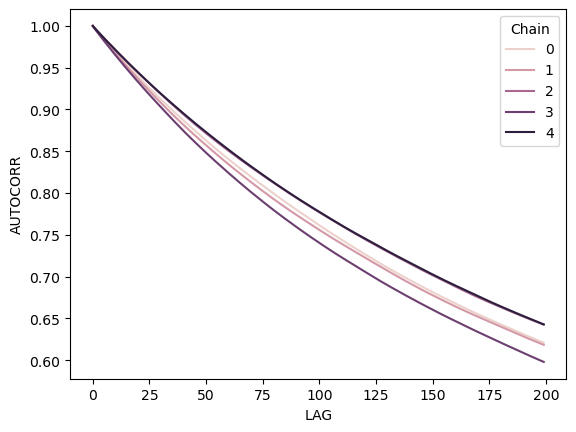

In [29]:
sample_eval.autocorrelation_plot()

### 2. Plot Single Parameters

In [18]:
def autocorrelation_singleparam(params_eval):
    max_lag = 7000
    #to get normalized correlation
    params_chain_a = (params_eval- np.mean(params_eval)) / (np.std(params_eval) * len(params_eval))
    params_chain_b = (params_eval - np.mean(params_eval)) / np.std(params_eval)
    ac_param = correlate(params_chain_a, params_chain_b)
    half_idx = len(ac_param)//2
    ac_param = ac_param[half_idx:(half_idx + max_lag)]
    return ac_param

def calculate_autocorrelation(params_chains):
    AC = {'Burn-in' : [], 'Chain':[], 'LAG' : [],'#Burn-in': [], 'AUTOCORR': []}
    for chain in range(nr_chains):
        params_chain= params_chains[chain]

        ac = np.apply_along_axis(autocorrelation_singleparam, arr = params_chain, axis = 0)
        fig, axs = plt.subplots()
        for param in range(ac.shape[1]):
            df = pd.DataFrame(ac[:,param], columns = ['Samples'])
            ax = sns.lineplot(data = df, x = df.index, y = 'Samples', legend = False)
            ax.set_title(f'Chain {chain + 1}')
        

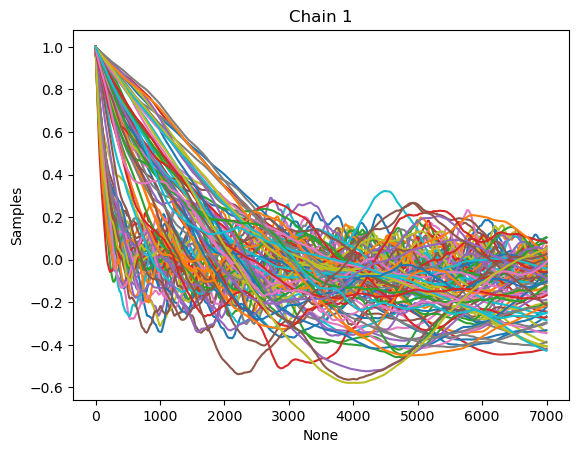

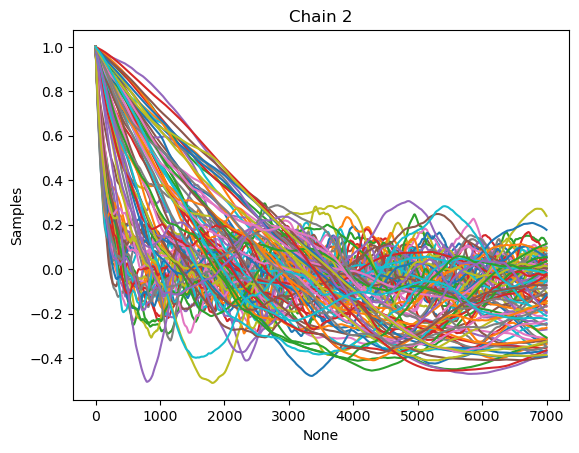

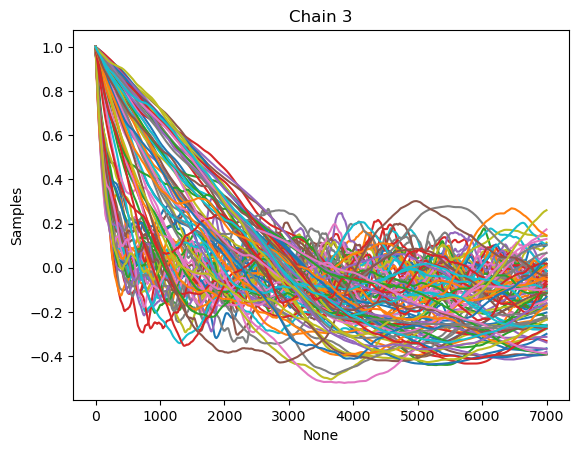

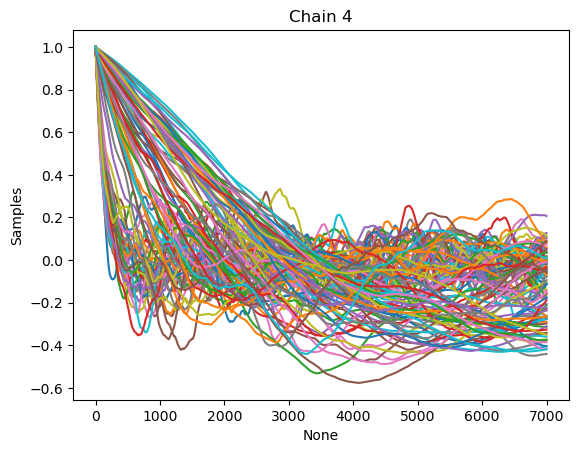

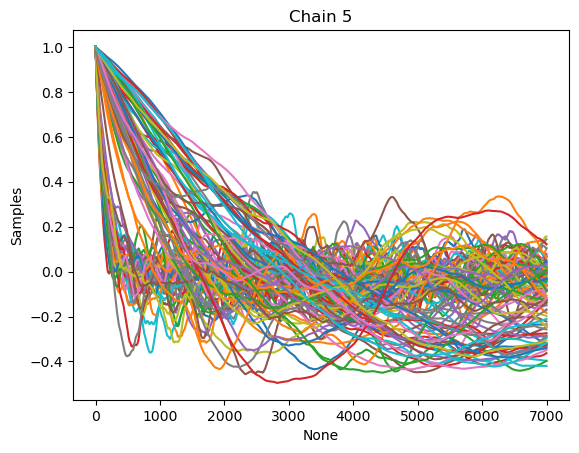

In [19]:
calculate_autocorrelation(params_eval)

## Trace Plot

In [20]:
params_eval = filter_params_reduced(params_reduced, 1000, return_layer=True)

In [21]:
def trace_plot(params, nr_plotsamples):
    fig, axs = plt.subplots(ncols = 1, nrows=len(params), figsize = (10,20))      
    nr_chains = len(params)   
    
    for idx_param, params_layer in enumerate(params):
        params_filtered = pd.DataFrame({})
        nr_params_layer= params_layer.shape[2]
        for chain in range(nr_chains):
            params_layer_chain = pd.DataFrame(params_layer [chain], columns = [f'Param{i}' for i in range(nr_params_layer)])
            params_layer_chain = params_layer_chain.iloc[:nr_plotsamples]
            params_layer_chain['Sample'] = range(len(params_layer_chain))

            params_layer_chain_long = params_layer_chain.melt(id_vars = 'Sample', var_name = 'Param', value_name = 'Value')
            params_layer_chain_long['Chain'] = chain + 1
            params_filtered = pd.concat((params_filtered, params_layer_chain_long))

        
        ax = sns.lineplot(data = params_filtered, x = 'Sample', y = 'Value', hue = 'Param', style = 'Chain', legend = False, ax = axs[idx_param])
        ax.set_title(param_names[idx_param])
        ax.set_xlabel('')
    plt.tight_layout()
    plt.show()

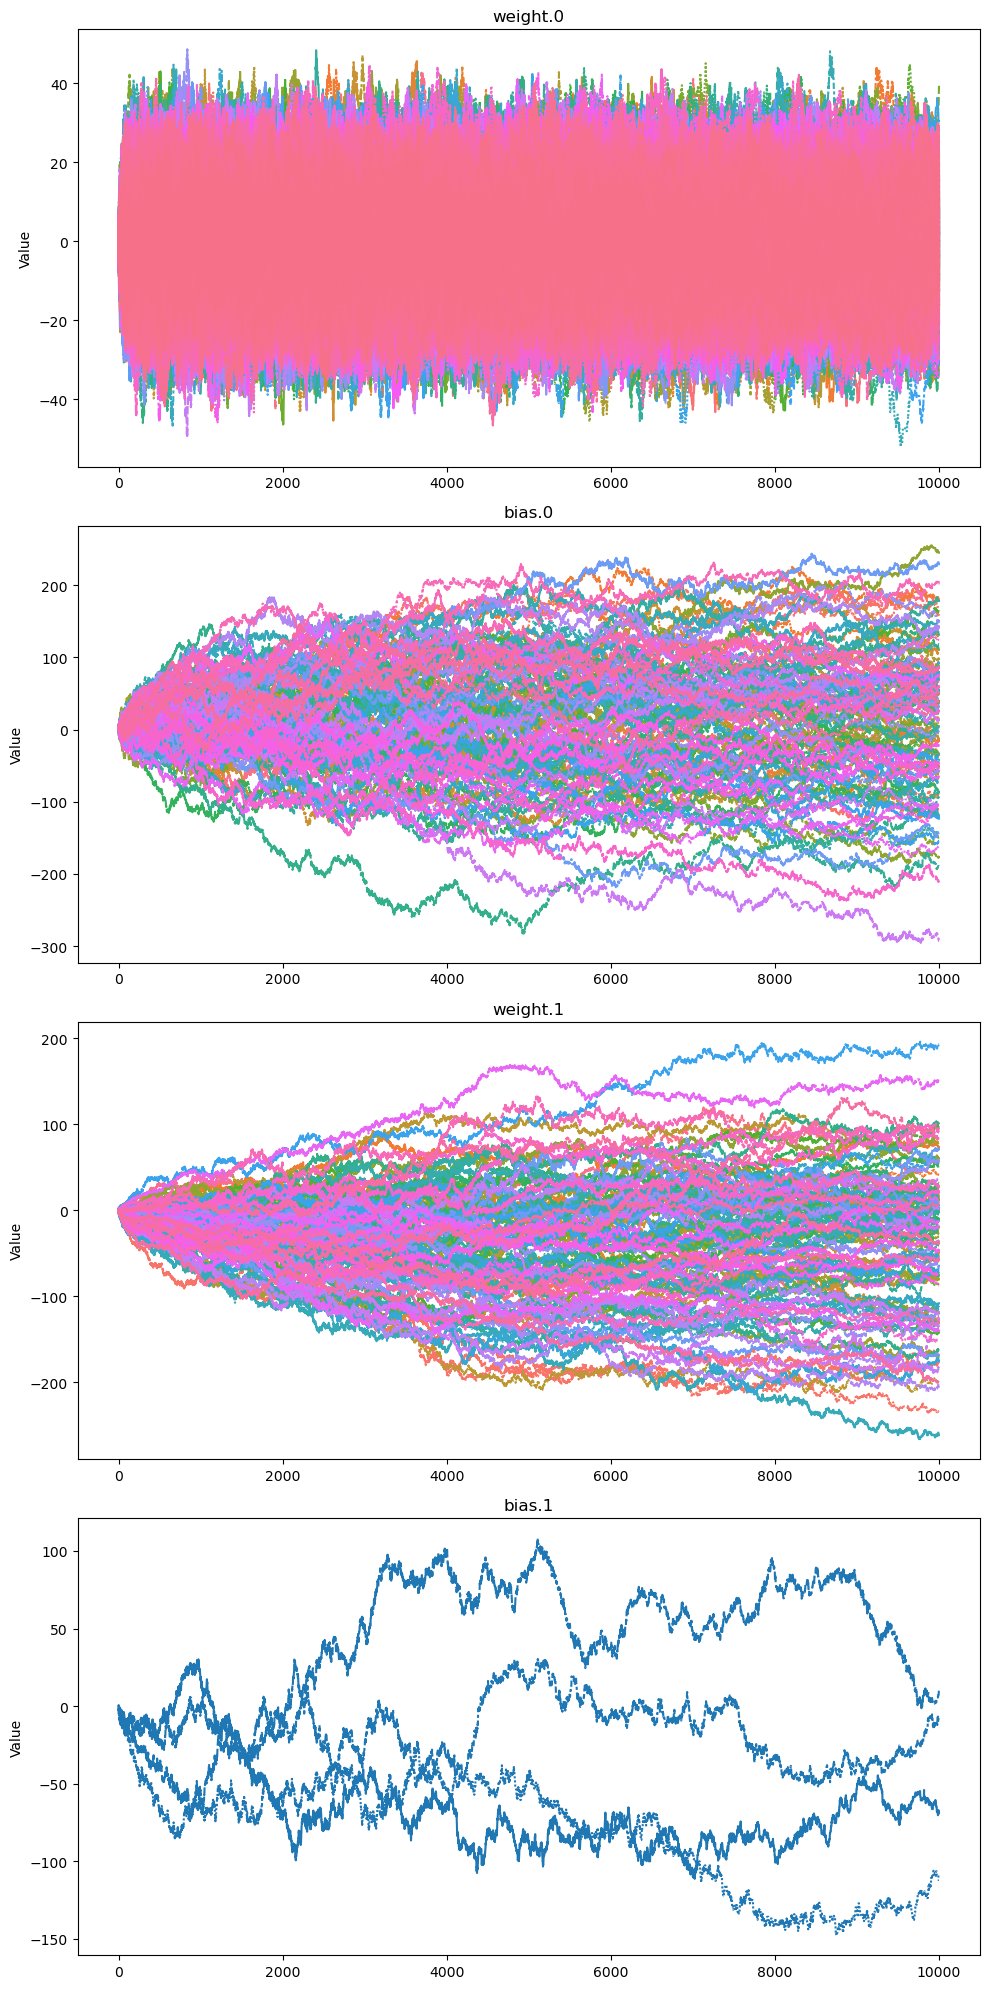

In [22]:
trace_plot(params_eval, 10000)

## RHAT

In [24]:
# All parameters

params_eval = filter_params_reduced(params_reduced, 200, return_layer=False)

sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
rhat = sample_eval.split_rhat(burnin = 0)
rhat_rn = sample_eval.split_rhat(burnin = 0, rank_normalized = True)

print(f'Parameter: Across all Parameters')
print(f'Split-RHAT:')
print(f'{np.mean(rhat)} +/- {np.std(rhat)}')
print(f'RN-Split-RHAT:' )
print(f'{np.mean(rhat_rn)} +/- {np.std(rhat_rn)}')

Parameter: Across all Parameters
Split-RHAT:
1.5122768878936768 +/- 0.7774138450622559
RN-Split-RHAT:
1.39572956580938 +/- 0.5786659412719155


In [26]:
# for every layer

params_eval = filter_params_reduced(params_reduced, 200, return_layer=True)

for burnin in range(0, 5000, 500):
    print('==============')
    print(f'Burnin {burnin}')
    for idx, params in enumerate(params_eval):
        sample_eval = HMCSampleEvaluation(params, 4096, hidden_sizes, reduce = False)
        rhat = sample_eval.split_rhat(burnin = burnin)
        rhat_rn = sample_eval.split_rhat(burnin = burnin, rank_normalized = True)


        print(f'Parameter: {param_names[idx]}')
        print(f'Split-RHAT:')
        print(f'{np.mean(rhat)} +/- {np.std(rhat)}')
        print(f'RN-Split-RHAT:' )
        print(f'{np.mean(rhat_rn)} +/- {np.std(rhat_rn)}')

Burnin 0
Parameter: weight.0
Split-RHAT:
1.0426462888717651 +/- 0.020205020904541016
RN-Split-RHAT:
1.0423822589900547 +/- 0.020233802800635702
Parameter: bias.0
Split-RHAT:
2.4213755130767822 +/- 0.45346084237098694
RN-Split-RHAT:
2.085814256381729 +/- 0.3323902403836162
Parameter: weight.1
Split-RHAT:
2.7659404277801514 +/- 0.6214358806610107
RN-Split-RHAT:
2.328552949421557 +/- 0.42392030238414097
Parameter: bias.1
Split-RHAT:
2.0606672763824463 +/- 0.0
RN-Split-RHAT:
1.9759461026090699 +/- 0.0
Burnin 500
Parameter: weight.0
Split-RHAT:
1.0467283725738525 +/- 0.023106366395950317
RN-Split-RHAT:
1.0464019736487415 +/- 0.023106736880442704
Parameter: bias.0
Split-RHAT:
2.5961694717407227 +/- 0.5539706945419312
RN-Split-RHAT:
2.1709166661116437 +/- 0.3641357091776884
Parameter: weight.1
Split-RHAT:
3.0020241737365723 +/- 0.7119568586349487
RN-Split-RHAT:
2.4311017186029176 +/- 0.4340137560459516
Parameter: bias.1
Split-RHAT:
2.1641438007354736 +/- 0.0
RN-Split-RHAT:
2.061635673970981 +

## Check ESS

In [22]:
# All parameters

params_eval = filter_params_reduced(params_reduced, 200, return_layer=False)

sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
sample_eval.calculate_autocorrelation()
ips = sample_eval.ips_per_chain(burnin = 0)
print(ips)


[29.23468806356903, 29.87691186347685, 29.40536126156531, 28.790385579101194, 29.86377541793585]
